In [24]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import image
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets,models,transforms
import shutil
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
with open('train_image.pkl', 'rb') as f:
    data = pickle.load(f)

In [6]:
image = np.array(data)
image = np.reshape(image,(8000,28,28))

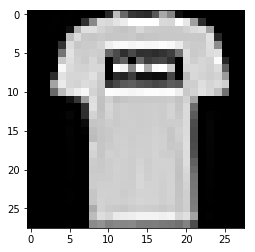

In [8]:
plt.imshow(image[0],cmap='gray')

In [9]:
image_data = np.reshape(image,(8000,28,28,1))

In [10]:
with open('train_label.pkl', 'rb') as g:
    labels = pickle.load(g)

In [11]:
classes = set(labels)
classes

{0, 2, 3, 6}

In [ ]:
import os
os.mkdir('train')

for i in classes:
    os.mkdir('train/'+str(i))

In [ ]:
os.mkdir('valid')

for i in classes:
    os.mkdir('valid/'+str(i))

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_data, labels, test_size=0.20, random_state=42)

In [ ]:
for i in range(X_train.shape[0]):
    img = Image.fromarray(np.array(X_train[i].reshape(28,28)).astype('uint8'))
    img.save('train/'+str(y_train[i])+'/'+str(i)+'.jpg')

for i in range(X_valid.shape[0]):
    img = Image.fromarray(np.array(X_valid[i].reshape(28,28)).astype('uint8'))
    img.save('valid/'+str(y_valid[i])+'/'+str(i)+'.jpg')

In [12]:
trans = transforms.Compose([transforms.Grayscale(3),transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
trainset = datasets.ImageFolder('train/',transform=trans)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=100,shuffle=True)

validset = datasets.ImageFolder('valid/',transform=trans)
validloader = torch.utils.data.DataLoader(validset,batch_size=100,shuffle=True)

In [13]:
def train(model,trainloader,validloader,opt,criterion,sched,epochs=10):
    model.cuda()
    for e in range(epochs):
        train_loss = 0
        train_accuracy = 0
        model.train()
        for images,labels in trainloader:
            images = images.cuda()
            labels = labels.cuda()
            log_probs = model(images)
            loss = criterion(log_probs,labels)
            ps = torch.exp(log_probs)
            _,top_class = ps.topk(1,dim=1)
            equals = top_class == labels.view(top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor))
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss.item()
        else:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for images,labels in validloader:
                    images = images
                    images = images.cuda()
                    labels = labels.cuda()
                    logps = model(images)
                    valid_loss += criterion(logps,labels)
                    ps = torch.exp(logps)
                    _,top_class = ps.topk(1,dim=1)
                    equals = top_class == labels.view(top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
            sched.step(valid_loss/len(validloader))
            print('epoch :{}/{} '.format(e+1,epochs),
                'train_loss :{:.3f} '.format(train_loss/len(trainloader)),
                'test_loss :{:.3f} '.format(valid_loss/len(validloader)),
                'test accuracy: {:.3f} '.format(accuracy/len(validloader)),
                'train accuracy: {:.3f}'.format(train_accuracy/len(trainloader)))
            if e%5 == 0:
                torch.save({'model_state':model.state_dict(),'optimizer_state':optimizer.state_dict()},'models_new_1c_conv_dropout_epoch40')
            

In [14]:
class my_model(nn.Module):
    def __init__(self,batch_size):
        super().__init__()
        self.bs = batch_size
        self.convol = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=2),
        
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=2),
        
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),
        
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=2),
        
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2),
        )
        
        self.fc = nn.Sequential(
                                nn.Linear(3200,2048),
                                nn.ReLU(),
                                 nn.Dropout(0.2),
                                nn.Linear(2048,1024),
                                nn.ReLU(),
                                 nn.Dropout(0.1),
                                nn.Linear(1024,512),
                                nn.ReLU(),
                                nn.Linear(512,256),
                                nn.ReLU(),
                                nn.Linear(256,4))
        
        
    def forward(self,x):
        x = self.convol(x)
        x = x.view(self.bs,-1)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        x = F.log_softmax(x,dim=1)
        return x

In [15]:
model = my_model(batch_size = 100)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 5)

In [ ]:
train(model=model,trainloader=trainloader,validloader=validloader,opt=optimizer,criterion=criterion,sched=scheduler,epochs=100)

In [ ]:
torch.save({'model_state':model.state_dict(),'optimizer_state':optimizer.state_dict()},'models_new_1c_conv_dropout_epoch40')

In [25]:
st_dict = torch.load('models_new_3cconv_dropout_epoch40',map_location='cpu')

In [26]:
model = my_model(batch_size = 1)

In [27]:
model.load_state_dict(st_dict['model_state'])

In [28]:
with open('test_image.pkl', 'rb') as c:
    data = pickle.load(c)

In [29]:
len(data)

2000

In [30]:
imgs = np.array(data)
test_imgs = np.reshape(imgs,(2000,28,28,1))

In [31]:
trans = transforms.Compose([transforms.Grayscale(3),transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])

In [32]:
label_mp = {'tensor(0)':0,'tensor(1)':2,'tensor(2)':3,'tensor(3)':6}

In [33]:
model.eval()
test_label = []
for i in range(test_imgs.shape[0]):
    img = Image.fromarray(np.array(test_imgs[i].reshape(28,28)).astype('uint8'))
    img = trans(img)
    img = torch.unsqueeze(img,dim=0)
    log_ps = model(img)
    ps = torch.exp(log_ps)
    _,top_cl = ps.topk(1,dim=1)
    test_label.append(top_cl[0][0])

In [34]:
orig_labels = [label_mp[str(i)] for i in test_label]

In [35]:
all_rows = []
for i in range(len(orig_labels)):
    l = []
    l.append(i)
    l.append(orig_labels[i])
    all_rows.append(l)

Preds = pd.DataFrame(all_rows,columns=['image_index','class'])
Preds.to_csv('submission.csv',index = False)